In [9]:
from Convert_Data import get_train_data, convert_train_data

X, y = convert_train_data(get_train_data("Dataset/train_fixed.csv"))

,Liquidity1,Liquidity2,Liquidity3,Liquidity4,Profitability1,Profitability2,Profitability3,Profitability4,Profitability5,Profitability6,...,Sector_Consumer Durables,Sector_Consumer Non-Durables,Sector_Consumer Services,Sector_Energy,Sector_Finance,Sector_Health Care,Sector_Miscellaneous,Sector_Public Utilities,Sector_Technology,Sector_Transportation
0,0.818622,0.505423,0.071419,16.428318,0.078944,0.125334,1.000000,0.125334,0.093049,0.181247,...,False,False,False,True,False,False,False,False,False,False
1,4.305054,1.863224,0.666396,58.294042,0.037622,0.026693,0.192896,0.073687,0.040609,0.034849,...,False,False,True,False,False,False,False,False,False,False
2,1.597586,0.214074,0.046990,11.152680,0.020515,0.029224,0.059090,0.029224,0.032161,0.068507,...,False,True,False,False,False,False,False,False,False,False
3,2.865716,1.642086,0.488048,53.320641,0.016414,0.014501,0.098816,0.016414,0.031327,0.036494,...,False,False,False,False,False,False,False,False,False,False
4,1.811393,1.164283,0.342700,43.407321,0.268651,0.272626,0.876273,0.362873,0.156983,0.187025,...,False,False,False,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1617,1.812725,1.153449,0.410435,459.746334,0.006569,-0.039869,0.346267,0.037361,0.000743,-0.005580,...,False,False,False,False,False,False,False,False,False,False
1618,0.945894,0.426395,0.099690,44.203245,0.037480,0.049351,0.176631,0.061510,0.041189,0.091514,...,True,False,False,False,False,False,False,False,False,False
1619,1.053107,0.545159,0.023483,55.470367,0.069389,0.109203,1.000000,0.145490,0.023160,0.040728,...,False,False,False,False,False,False,False,True,False,False
1620,0.310328,0.298394,0.124943,6.900492,0.041311,0.066799,0.692435,0.079302,0.042483,0.077366,...,False,False,False,False,False,False,False,False,True,False


In [3]:
class_counts = y.value_counts()
class_percentage = class_counts / len(y) * 100 
print(class_percentage)

Rating
1    33.230580
0    24.352651
2    23.921085
3    18.495684
Name: count, dtype: float64


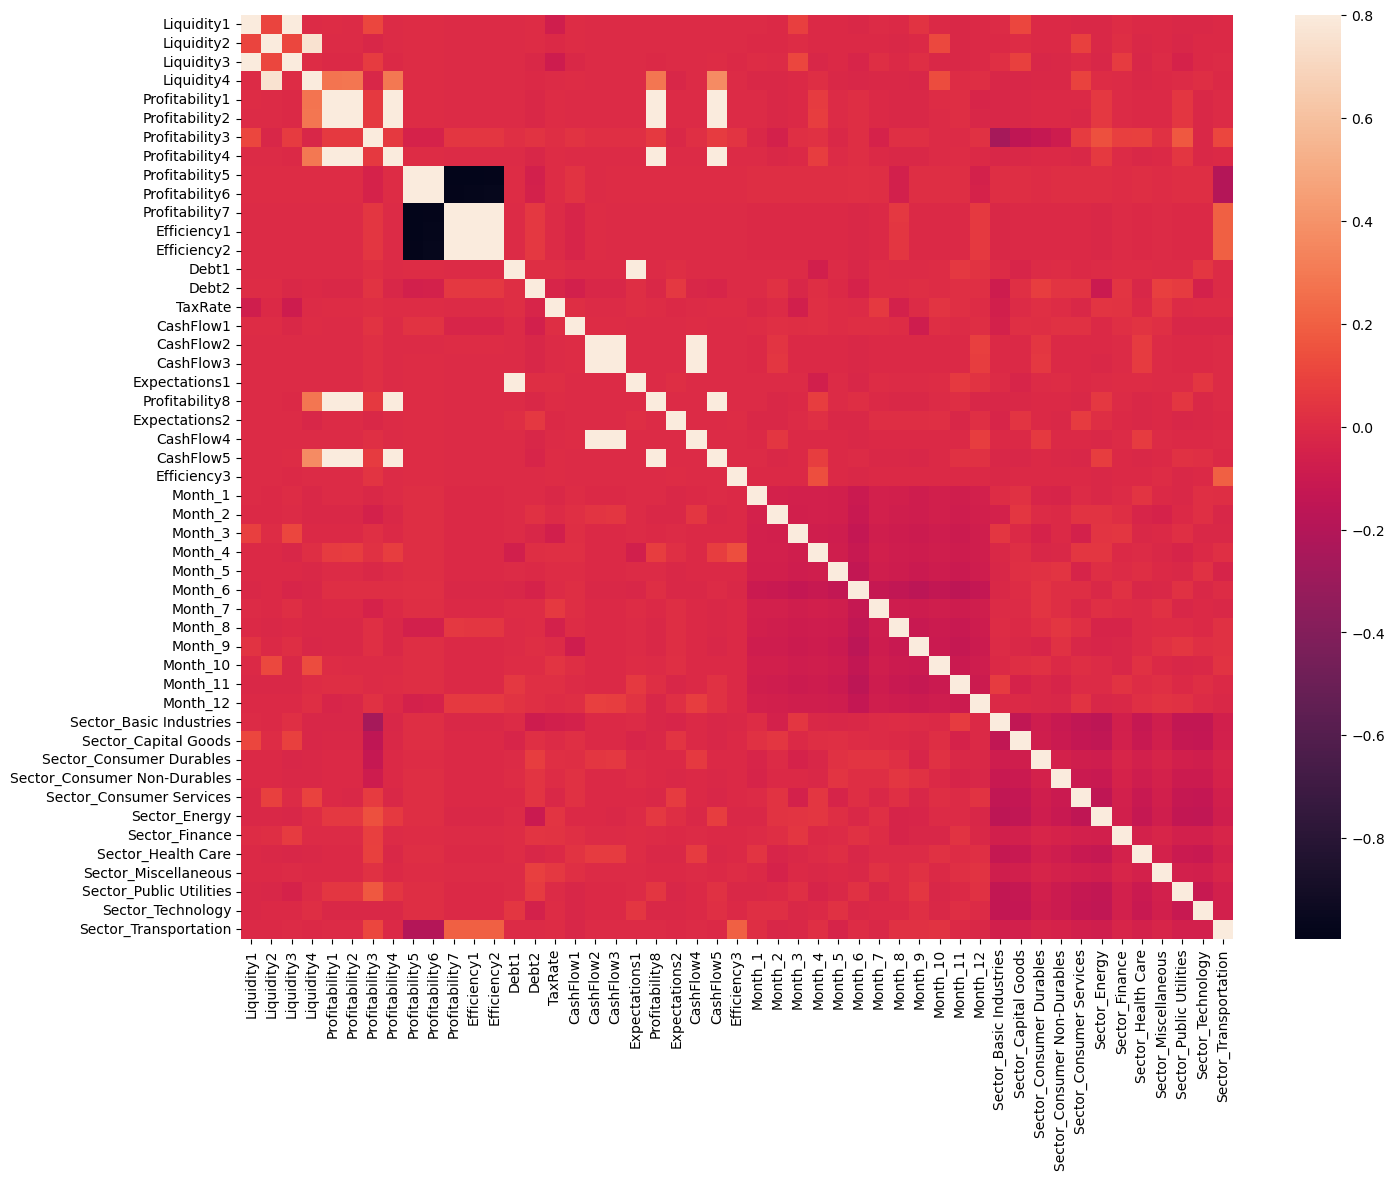

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
#%matplotlib inline

correlation_matrix = X.corr()
fig = plt.figure(figsize = (16, 12))
sns.heatmap(correlation_matrix, vmax = 0.8)
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split

#X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, stratify=y, random_state=0)

In [20]:
from model_library import find_params, find_params_grid
from hyperopt import hp
import numpy as np

space = {
    'n_estimators': hp.choice('n_estimators', range(1000, 1200, 50)),
    'max_depth': hp.choice('max_depth', range(14, 18, 1)),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.05), np.log(0.2)),
    'subsample': hp.uniform('subsample', 0.5, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
    'gamma': hp.uniform('gamma', 0, 1.0),
    'reg_alpha': hp.uniform('reg_alpha', 0, 1.0),
    'reg_lambda': hp.uniform('reg_lambda', 0, 1.0),
    'min_child_weight': hp.quniform('min_child_weight', 3, 6, 1)
}


find_params(X, y, space, "temp8")

NEW_BEST!                                                
Avg Custom Loss: 461.0                                   
NEW_BEST!                                                                
Avg Custom Loss: 442.0                                                   
  0%|          | 6/10000 [18:58<526:49:54, 189.77s/trial, best loss: 442.0] 


KeyboardInterrupt: 

In [19]:
from model_library import loss_fn
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold
import xgboost as xgb

params = {
    'colsample_bytree': 0.69,
    'gamma': 0.017,
    'learning_rate': 0.116,
    'max_depth': 16,
    'min_child_weight': 4.0,
    'n_estimators': 1100,
    'objective': 'multi:softprob',
    'eval_metric': 'mlogloss',
}

kf = StratifiedKFold(n_splits=5)
accuracies = []
f1_scores = []
custom_losses = []


for train_index, test_index in kf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Train the model
    model = xgb.XGBClassifier(**params)
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Calculate metrics
    accuracies.append(accuracy_score(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    custom_loss = loss_fn(cm)
    custom_losses.append(custom_loss)

# Print the average results
print(f"Average Accuracy: {np.mean(accuracies)}")
print(f"Average Custom Loss: {np.mean(custom_losses)}")

Average Accuracy: 0.5616353276353276
Average Custom Loss: 267.4


In [8]:
from Convert_Data import convert_test_data, get_test_data

X_test = convert_test_data(get_test_data("Dataset/test_fixed.csv"))

Liquidity1                       float64
Liquidity2                       float64
Liquidity3                       float64
Liquidity4                       float64
Profitability1                   float64
Profitability2                   float64
Profitability3                   float64
Profitability4                   float64
Profitability5                   float64
Profitability6                   float64
Profitability7                   float64
Efficiency1                      float64
Efficiency2                      float64
Debt1                            float64
Debt2                            float64
TaxRate                          float64
CashFlow1                        float64
CashFlow2                        float64
CashFlow3                        float64
Expectations1                    float64
Profitability8                   float64
Expectations2                    float64
CashFlow4                        float64
CashFlow5                        float64
Efficiency3     

In [10]:
import pandas as pd
y_pred_test = model["model"].predict(X_test)
pd.DataFrame(y_pred_test).to_csv("answers.csv", index=False)

In [13]:
answers = model["model"].predict(X_test)
answers

array([1, 1, 1, ..., 3, 3, 3])

In [4]:
answers = pd.read_csv("answers.csv")
dictionary_ans = {'Low Risk': 0, 'Medium Risk': 1, 'High Risk': 2, 'Highest Risk': 3}

for k, i in dictionary_ans.items():
    answers=answers.replace(i, k, )
answers.to_csv("answers.csv", index=False)

In [5]:
answers = pd.read_csv("answers.csv")
answers

,0
0,1
1,1
2,1
3,1
4,0
...,...
1887,3
1888,3
1889,3
1890,3
